In [102]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import metrics, tree, svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

from matplotlib import pyplot as plt

In [103]:
df = pd.read_csv("dataset/oasis_longitudinal.csv")

# Remove ID since no correlation with data. Also remove Hand since there is no variance (everyone is right handed)
# ASF is also removed since is directly correlated with eTIV (Linear combination of eTIV)
df.drop(columns=["Subject ID", "MRI ID", "Hand", "ASF"], inplace=True)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     373 non-null    object 
 1   Visit     373 non-null    int64  
 2   MR Delay  373 non-null    int64  
 3   M/F       373 non-null    object 
 4   Age       373 non-null    int64  
 5   EDUC      373 non-null    int64  
 6   SES       354 non-null    float64
 7   MMSE      371 non-null    float64
 8   CDR       373 non-null    float64
 9   eTIV      373 non-null    int64  
 10  nWBV      373 non-null    float64
dtypes: float64(4), int64(5), object(2)
memory usage: 32.2+ KB


In [105]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000


### Preprocessing

In [106]:
# Process categorical data (Group & M/F)
df['Group'] = df['Group'].replace({'Demented': 1, 'Converted': 1, 'Nondemented': 0})
map = pd.get_dummies(df['M/F'], prefix='is')
df = pd.concat([df, map], axis=1)
df.drop(columns='M/F', inplace=True)

# Process missing entries.
# Decided to fill with mean since don't want to shrink already small dataset
df = df.fillna(df.mean())
# df.dropna(inplace=True)
# df.bfill(inplace=True, limit=None)
# df.ffill(inplace=True, limit=None)

# Removing outliers did not improve cv error
# for feature in ['MR Delay', 'Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF']:
#     datapoints = df[feature]
#     mean = datapoints.mean()
#     std = datapoints.std()
#     outliers = (datapoints < mean-3*std) | (datapoints > mean+3*std)
#     df.drop(index=df[outliers].index, inplace=True)

df

C:\Users\benja\AppData\Local\Temp\ipykernel_18728\819027520.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Group'] = df['Group'].replace({'Demented': 1, 'Converted': 1, 'Nondemented': 0})


,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,is_F,is_M
0,0,1,0,87,14,2.000000,27.0,0.0,1987,0.696,False,True
1,0,2,457,88,14,2.000000,30.0,0.0,2004,0.681,False,True
2,1,1,0,75,12,2.460452,23.0,0.5,1678,0.736,False,True
3,1,2,560,76,12,2.460452,28.0,0.5,1738,0.713,False,True
4,1,3,1895,80,12,2.460452,22.0,0.5,1698,0.701,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
368,1,2,842,82,16,1.000000,28.0,0.5,1693,0.694,False,True
369,1,3,2297,86,16,1.000000,26.0,0.5,1688,0.675,False,True
370,0,1,0,61,13,2.000000,30.0,0.0,1319,0.801,True,False
371,0,2,763,63,13,2.000000,30.0,0.0,1327,0.796,True,False


In [107]:
# Partition data
y = df['Group']
X = df.drop(columns='Group')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=156)

In [108]:
# Our data is approximately normal so StandardScaler should perform well
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Functions

In [109]:
def roc_auc():
    predict_prob = model.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()

In [110]:
def confusion_matrix():
    matrix = metrics.confusion_matrix(y_test, prediction)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()

In [111]:
def bootstrap():
    accuracy = []
    n_iterations = 1000
    for i in range(n_iterations):
        X_sparse, y_sparse = resample(X_test, y_test, replace=True)
        predict = model.predict(X_sparse)
        score = metrics.accuracy_score(y_sparse, predict)
        accuracy.append(score)

    median = np.median(accuracy)
    lower = np.percentile(accuracy, 2.5)
    upper = np.percentile(accuracy, 97.5)

    print(f'The median is {median:.2f} '
        f'with a confidence interval of [{lower:.2f}, {upper:.2f}].')

    sns.kdeplot(accuracy)
    plt.title('1000 Bootstrap Samples of Test Set')
    plt.xlabel('Accuracy')
    plt.axvline(median, 0, 16)
    plt.axvline(lower, 0, 16, linestyle="--", color="red")
    plt.axvline(upper, 0, 16, linestyle="--", color="red")

### Logistic Regression

In [112]:
# Logistic regression hyperparameter tuning.
# Tests 100 penalty values per combination.
C = np.arange(0.1,10,0.1)
params = [
          {'penalty': ['l1'],
           'solver': ['liblinear', 'saga'],
           'C': C},
          {'penalty': ['l2'],
           'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
           'C': C}
         ]

# Using LeaveOneOut cv since our dataset is relativelty small. Keeps bias low.
model = GridSearchCV(estimator=LogisticRegression(n_jobs=-1, max_iter=1000), param_grid=params, n_jobs=-1, scoring='accuracy', cv=LeaveOneOut())
model.fit(X_train, y_train)
model.best_params_, model.best_score_

C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(


({'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 0.9496644295302014)

<Axes: xlabel='liblinear penalty'>

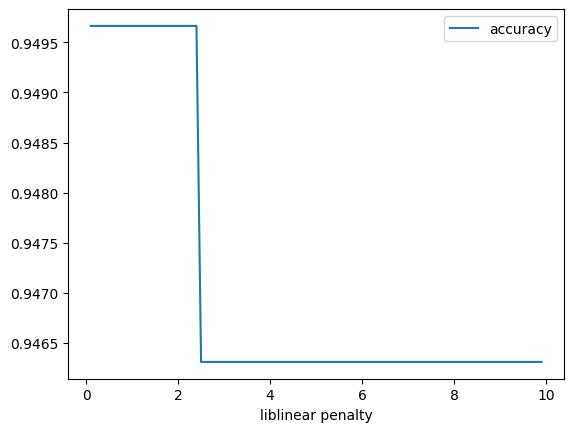

In [113]:
df = pd.DataFrame()
df['liblinear penalty'] = np.arange(0.1,10,0.1)
df['accuracy'] = model.cv_results_['mean_test_score'][0:198:2]
df.plot(x='liblinear penalty')

In [114]:
# Best CV score is 0.95 with C=0.1, lasso, liblinear
# Makes sense since liblinear is great for small datasets and where the output variable is binary
prediction = model.predict(X_test)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.86      0.93        37

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



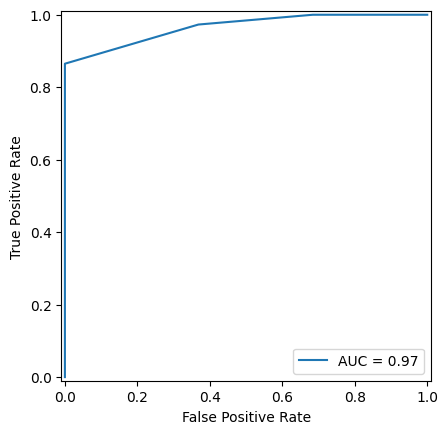

In [115]:
# Comparing AUC score is important since we want a model where TP rate is high to reduce chance of missing a demented patient.
# Also want low FP to avoid misdiagnosis.
roc_auc()

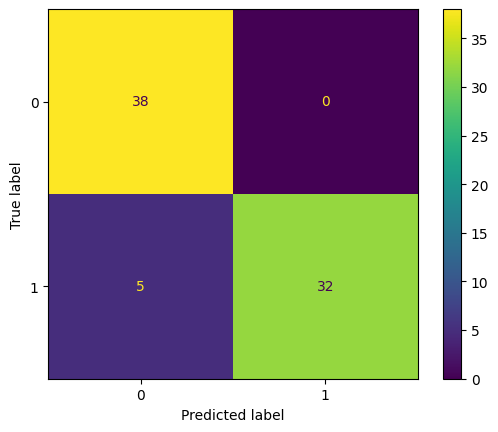

In [116]:
confusion_matrix()

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.86      0.93        37

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



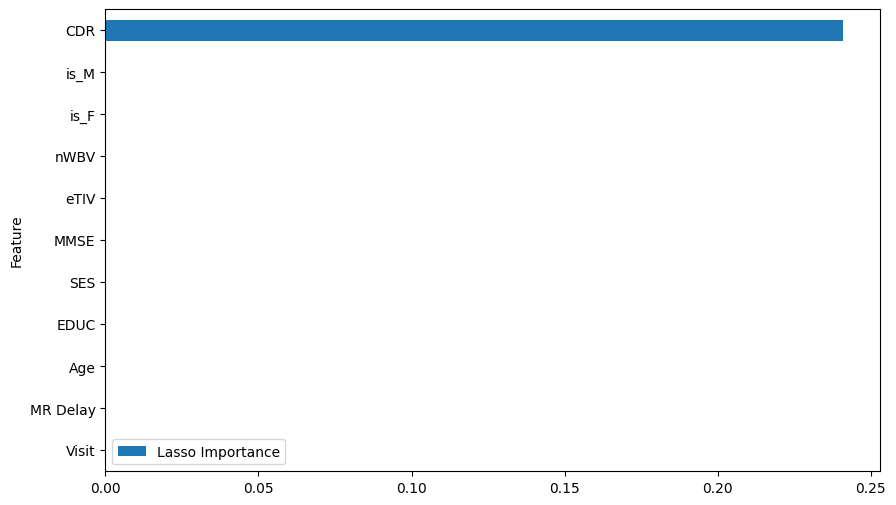

In [117]:
# Lasso seems to simplify complexity of model by only using CDR but accuracy does not improve.
model = LogisticRegression(solver='liblinear', penalty='l1', C=0.01)
model.fit(X_train, y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Lasso Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Lasso Importance', ascending=True)
feature_importance.plot(x='Feature', y='Lasso Importance', kind='barh', figsize=(10, 6))

prediction = model.predict(X_test)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.86      0.93        37

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



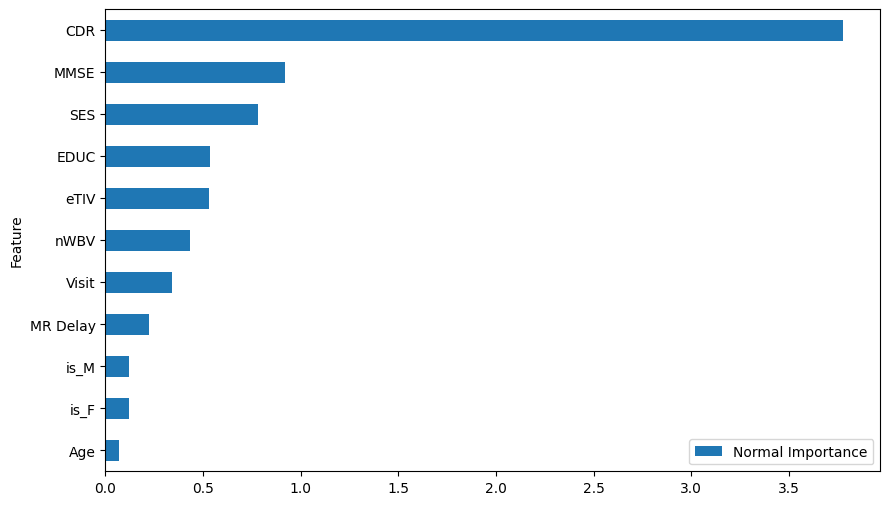

In [118]:
# No lasso
model = LogisticRegression()
model.fit(X_train, y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Normal Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Normal Importance', ascending=True)
feature_importance.plot(x='Feature', y='Normal Importance', kind='barh', figsize=(10, 6))

prediction = model.predict(X_test)
print(metrics.classification_report(y_test, prediction))

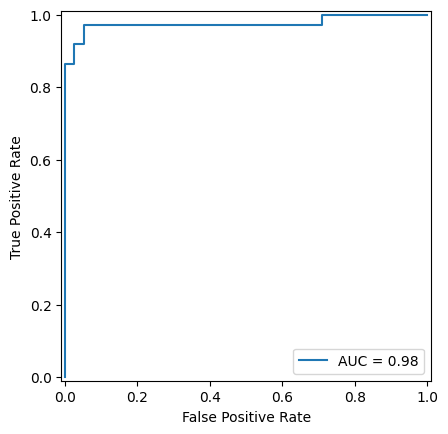

In [119]:
# Slightly better with no lasso!
roc_auc()

The median is 0.93 with a confidence interval of [0.87, 0.99].


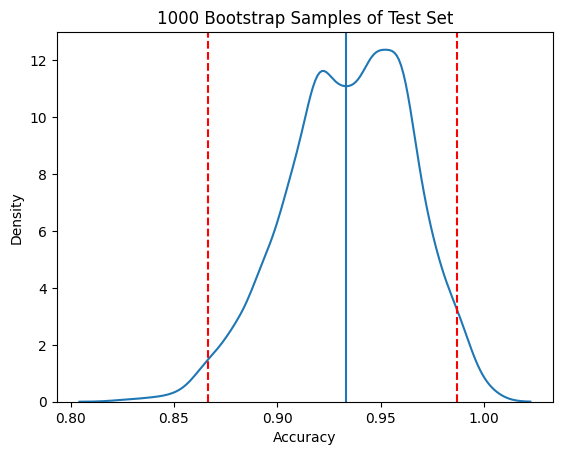

In [120]:
bootstrap()

### Guassian

In [121]:
# Nothing we can really play with here. Slightly worse than logistic regression.
model = GaussianNB()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.86      0.93        37

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



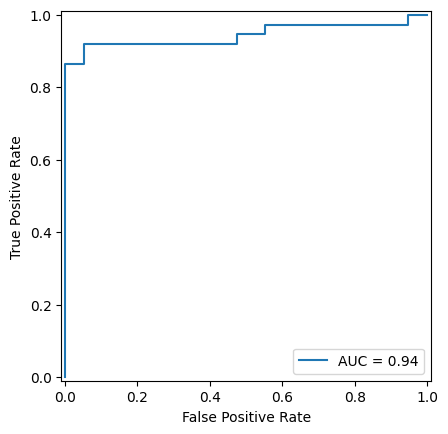

In [122]:
roc_auc()

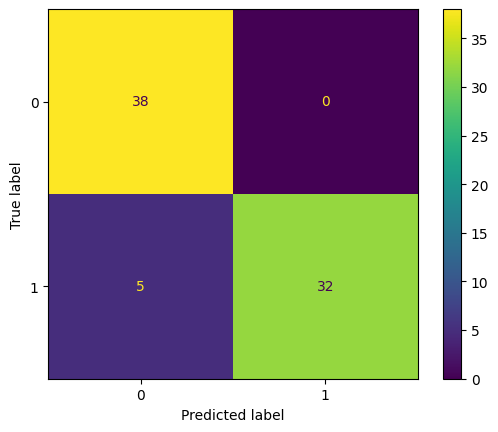

In [123]:
confusion_matrix()

The median is 0.93 with a confidence interval of [0.87, 0.99].


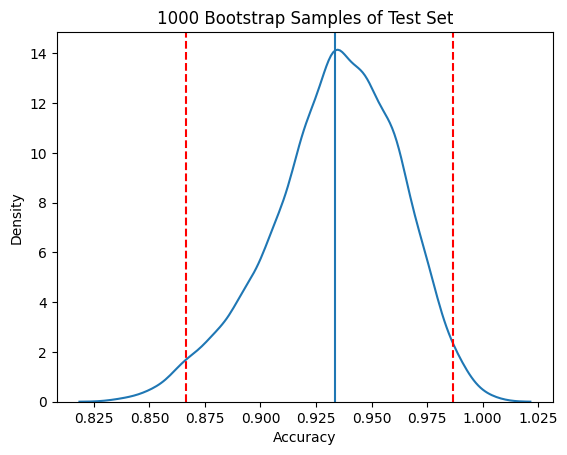

In [124]:
bootstrap()

### KNN

In [125]:
params = {
          'n_neighbors': range(2,25),
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
         }

model = GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), param_grid=params, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

model.best_params_, model.best_score_

({'algorithm': 'auto', 'n_neighbors': 5}, 0.9026845637583892)

<Axes: xlabel='K'>

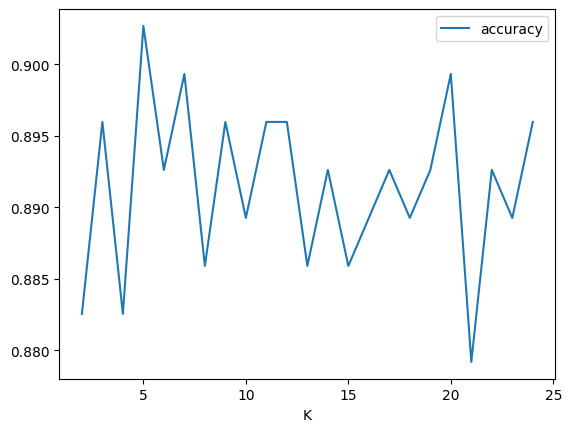

In [126]:
df = pd.DataFrame()
df['K'] = range(2,25)
df['accuracy'] = model.cv_results_['mean_test_score'][0:23]
df.plot(x='K')

In [127]:
# Best model is K=5
prediction = model.predict(X_test)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91        38
           1       0.97      0.84      0.90        37

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



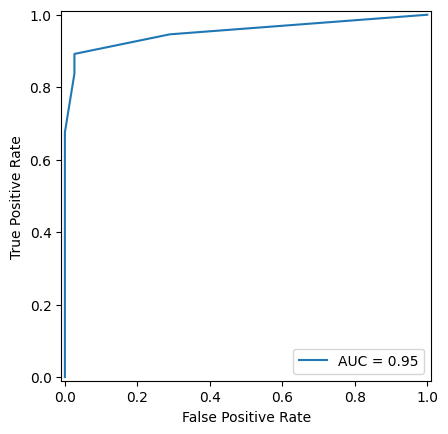

In [128]:
roc_auc()

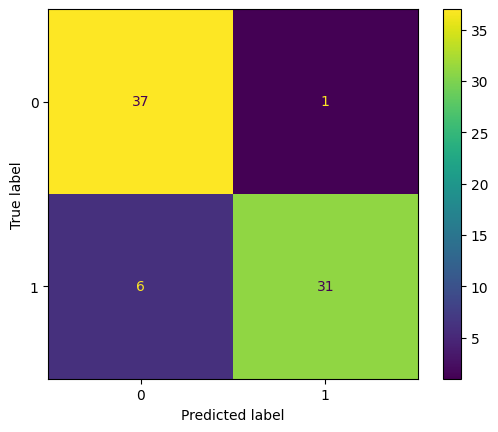

In [129]:
confusion_matrix()

The median is 0.91 with a confidence interval of [0.84, 0.96].


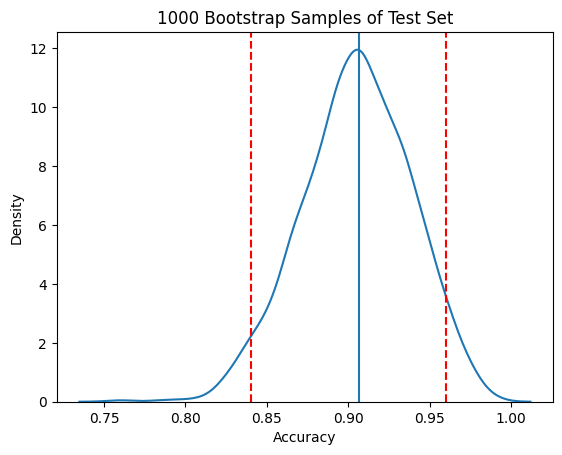

In [130]:
bootstrap()

### Decision Tree

In [131]:
params = {'max_depth': range(1,30)}

model = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=156), param_grid=params, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
model.fit(X_train, y_train)

model.best_params_, model.best_score_

({'max_depth': 1}, 0.9496644295302014)

<Axes: xlabel='depth'>

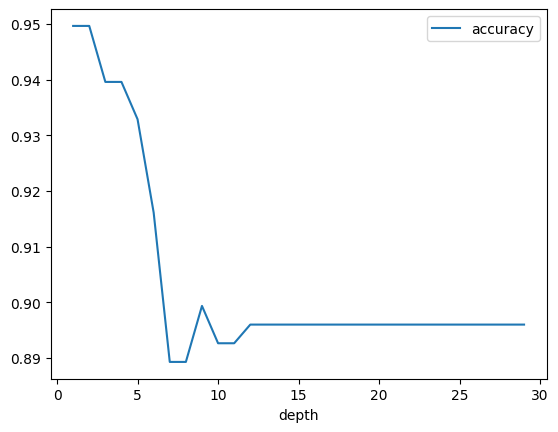

In [132]:
df = pd.DataFrame()
df['depth'] = range(1,30)
df['accuracy'] = model.cv_results_['mean_test_score']
df.plot(x='depth')

In [133]:
# Looks like all we need is one feature (CDR) to accurately predict with tree. Depth = 1
model = tree.DecisionTreeClassifier(max_depth=1, random_state=156)
model.fit(X_train, y_train)

model_text = tree.export_text(model, feature_names=list(X.columns))
print(model_text)

|--- CDR <= -0.12
|   |--- class: 0
|--- CDR >  -0.12
|   |--- class: 1



In [134]:
prediction = model.predict(X_test)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.86      0.93        37

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



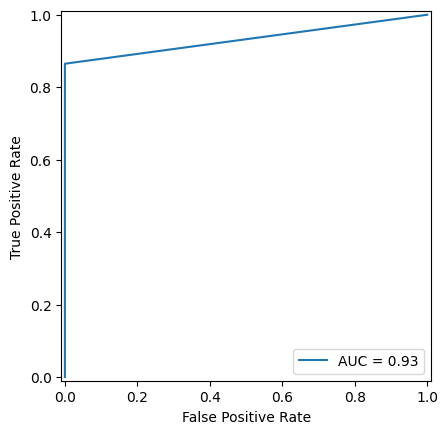

In [135]:
roc_auc()

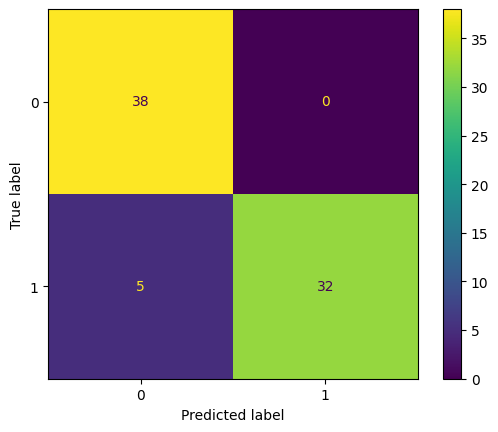

In [136]:
confusion_matrix()

The median is 0.93 with a confidence interval of [0.88, 0.99].


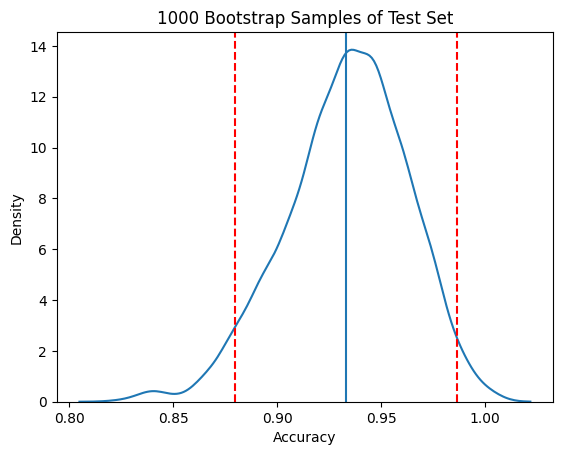

In [137]:
bootstrap()

### Support Vector Machine

In [138]:
model = svm.LinearSVC(dual=False)
print(np.mean(cross_val_score(model, X_train, y_train, cv=LeaveOneOut(), n_jobs=-1)))

0.9496644295302014


In [139]:
# Just test these kernels since we aren't doing multiclass classification
params = {'kernel': ['poly', 'rbf', 'linear']}

model = GridSearchCV(estimator=svm.SVC(), param_grid=params, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
model.fit(X_train, y_train)

model.best_params_, model.best_score_

({'kernel': 'poly'}, 0.9496644295302014)

In [140]:
# Accuracies for kernels are the same
prediction = model.predict(X_test)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.86      0.93        37

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



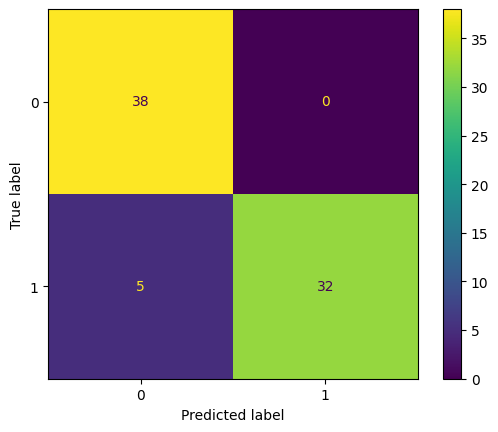

In [141]:
confusion_matrix()

The median is 0.93 with a confidence interval of [0.87, 0.99].


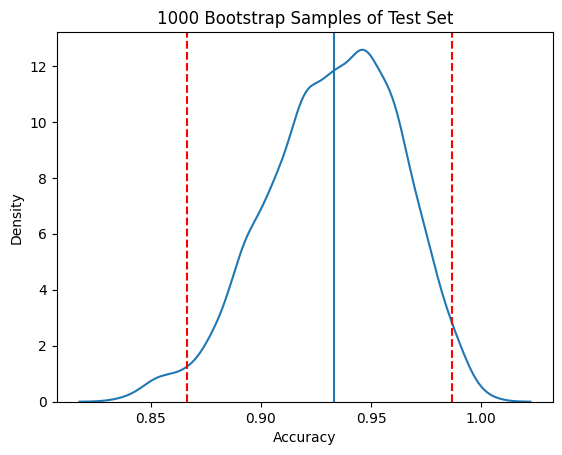

In [142]:
bootstrap()

Can't get roc curve for SVM since no thresholds...